In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import networkx as nx

# https://biopython.org/docs/1.74/api/Bio.SVDSuperimposer.html
# conda install conda-forge::biopython
from Bio.SVDSuperimposer import SVDSuperimposer
from tqdm import tqdm

# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 

%load_ext autoreload
%autoreload 2

/Users/thor/surfdrive/Projects/PMCpy/pmcpy/Evals/PyLk/pylk/writhemap.py:16: UserWarning: Cython version of writhemap (PyLk) not compiled. Defaulting to numba implementation. Consider compiling the cython version.
  warnings.warn(
/Users/thor/surfdrive/Projects/PMCpy/pmcpy/Evals/PyLk/pylk/eval_link.py:10: UserWarning: Cython version of linkingnumber (PyLk) not compiled. Defaulting to numba implementation. Consider compiling the cython version.
  warnings.warn(


In [56]:
traj = md.load('8srp.pdb')
protein = traj.atom_slice(traj.top.select('protein'))
view = nv.show_mdtraj(traj)
view

/Users/thor/miniforge3/envs/mdna/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


NGLWidget()

In [3]:
DNA_residue_names = ['DG','DC','DT','DA']
DNA_chainids = []
for chain in traj.top.chains:
    for res in chain._residues:
         if str(res.name) in DNA_residue_names:
            DNA_chainids.append(res.chain.index)
DNA_chainids = np.unique(DNA_chainids)
DNA_chainids = np.array([DNA_chainids[i:i + 2] for i in range(0, len(DNA_chainids), 2)])
DNA_chainids    

array([[2, 3],
       [4, 5]])

In [15]:
dna_a = mdna.load(traj=traj, chainids=DNA_chainids[0])
dna_b = mdna.load(traj=traj, chainids=DNA_chainids[1])

frames_a = dna_a.get_frames()
frames_b = dna_b.get_frames()
frames_a.shape, frames_b.shape

((54, 1, 4, 3), (53, 1, 4, 3))

In [47]:
start = np.squeeze(frames_a[-1])[0]
end = np.squeeze(frames_b[0])[0]

start_increment = start + np.array([0.5,0,3]) 
end_increment = end + np.array([-0.5,0,3])
center_of_mass = (start+end)/2
center_of_mass += np.array([0,0,1]) * 20
center_of_mass_left  = center_of_mass + np.array([4,0,-2])
center_of_mass_right  = center_of_mass + np.array([-4,0,-2])

control_points = np.array([start,start_increment,center_of_mass_left,center_of_mass,center_of_mass_right,end_increment,end])
control_points.shape

(7, 3)

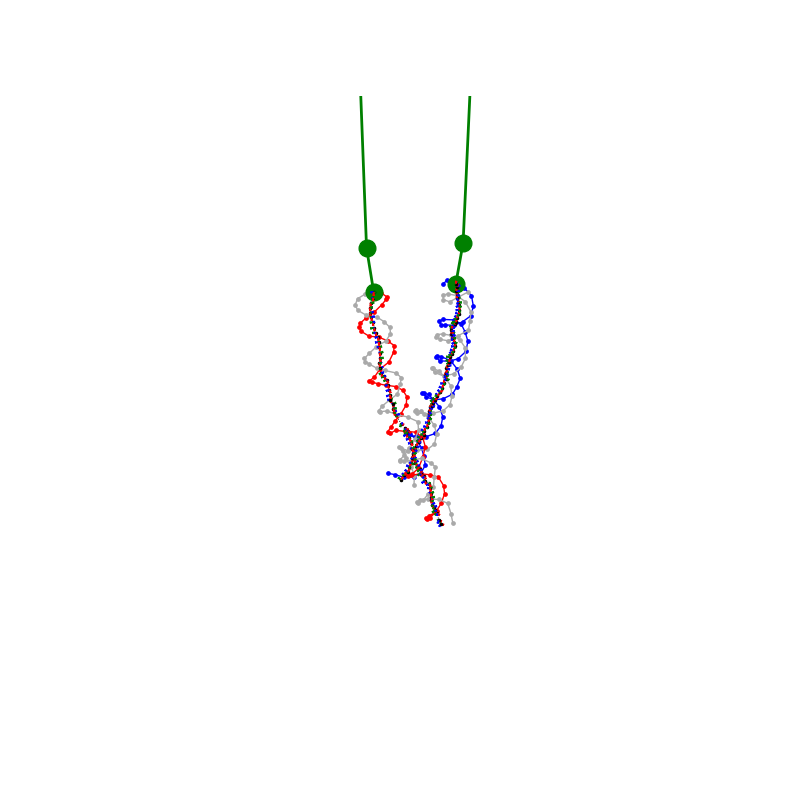

In [48]:
%matplotlib ipympl
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

dna_a.draw(ax=ax, triads=True,color_lead='blue')
dna_b.draw(ax=ax, triads=True,color_lead='red')

ax.plot(control_points[:,0], control_points[:,1], control_points[:,2], marker='o', color='g', linestyle='-', linewidth=2, markersize=12)

Optimal BP: 26, Twist Difference per BP: 0.176 degrees
Optimal number of base pairs: 26
Random sequence: CAATTGTGCAAGGTTCCAACGCAGGAGCCGAACACGTCCAGGTAAAAGCAACTGGCGTAGGGTCTTCTTATACCTAAGCGAGGAGGATTCTTTTGAGTGCAGACCGACCTGGACTCTGTACGTCTCCACCCTGTTC 

Minimize the DNA structure:
simple equilibration = False 
equilibrate writhe = False 
excluded volume radius = 0.0 
temperature = 300
Circular: False


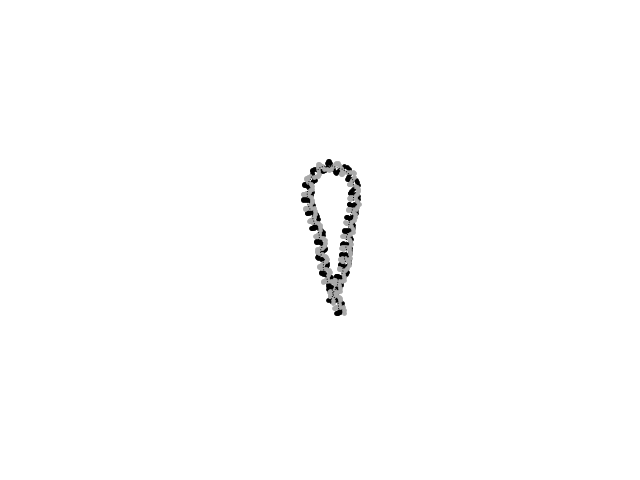

In [64]:
dna_c = mdna.connect(dna_a, dna_b, control_points=control_points)
dna_c.draw()


In [65]:
dna_traj = dna_c.get_traj()
connected_traj = protein.stack(dna_traj)
view = nv.show_mdtraj(connected_traj)
view

NGLWidget()

In [58]:
connected_traj.save('8srp_connected.pdb')